In [1]:
!pip uninstall box2d-py -y > /dev/null 2>&1
!pip install box2d-py > /dev/null 2>&1
!pip3 install box2d box2d-kengz > /dev/null 2>&1
!apt install xvfb > /dev/null 2>&1
!pip3 install pyvirtualdisplay > /dev/null 2>&1


# Important: Specify numpy version explicitly to fix a compatibility issue
!pip install numpy==1.23 gym==0.25.0 > /dev/null 2>&1

In [6]:
# Reminder for students
print("IMPORTANT: After numpy==1.23 was reinstalled, NOW please RESTART your runtime now (Runtime -> Restart runtime (Ctrl+M)) to ensure it is being used.")

IMPORTANT: After numpy==1.23 was reinstalled, NOW please RESTART your runtime now (Runtime -> Restart runtime (Ctrl+M)) to ensure it is being used.


In [1]:
# Imports (after restarting runtime)

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
import copy
%matplotlib inline

# Verify installed versions, you need to ensure numpy==1.23 gym==0.25.0 to run the other codes.
print(f" Current numpy version: {np.__version__}, gym version: {gym.__version__}")

 Current numpy version: 1.23.0, gym version: 0.25.0


We provide you with the following utility functions for this assignment: (1) the replay buffer for experience replay, and (2) a policy evaluation function which evaluates a policy with Monte Carlo.

In [2]:
# Replay buffer
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

# policy evaluation with Monte Carlo
def eval_policy(policy, env_name, seed, eval_episodes=10):
	eval_env = gym.make(env_name)
	eval_env.seed(seed + 100)

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _= eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward


In [3]:
# Implementation of Deep Deterministic Policy Gradients (DDPG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		############################
		# YOUR IMPLEMENTATION HERE #
		self.l1 = nn.Linear(state_dim, 400)
		self.l2 = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, action_dim)
		############################

		self.max_action = max_action


	def forward(self, state):
		############################
		# YOUR IMPLEMENTATION HERE #
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))
		############################


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		############################
		# YOUR IMPLEMENTATION HERE #
		self.l1 = nn.Linear(state_dim + action_dim, 400)
		self.l2 = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, 1)
		############################


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		############################
		# YOUR IMPLEMENTATION HERE #
		q = F.relu(self.l1(sa))
		q = F.relu(self.l2(q))
		return self.l3(q)
		############################


class DDPG(object):
	def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.001):
		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), weight_decay=1e-2)

		self.discount = discount
		self.tau = tau


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=64):
		# Sample replay buffer
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		# Compute the target Q value
		############################
		# YOUR IMPLEMENTATION HERE #
		target_Q = self.critic_target(next_state, self.actor_target(next_state))
		target_Q = reward + (not_done * self.discount * target_Q).detach()
		############################

		# Get current Q estimate
		current_Q = self.critic(state, action)

		# Compute critic loss
		############################
		# YOUR IMPLEMENTATION HERE #
		critic_loss = F.mse_loss(current_Q, target_Q)
		############################

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Compute actor loss
		############################
		# YOUR IMPLEMENTATION HERE #
		actor_loss = -self.critic(state, self.actor(state)).mean()
		############################

		# Optimize the actor
		self.actor_optimizer.zero_grad()
		actor_loss.backward()
		self.actor_optimizer.step()

		# Update the frozen target models
		for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
			############################
			# YOUR IMPLEMENTATION HERE #
			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
	    ############################

		for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
			############################
			# YOUR IMPLEMENTATION HERE #
			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
	    ############################


In [4]:
# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
class Actor_TD3(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor_TD3, self).__init__()

		############################
		# YOUR IMPLEMENTATION HERE #
		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
	  ############################

		self.max_action = max_action


	def forward(self, state):
		############################
		# YOUR IMPLEMENTATION HERE #
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))
		############################


class Critic_TD3(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic_TD3, self).__init__()

		# Q1 architecture
		############################
		# YOUR IMPLEMENTATION HERE #
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)
		############################

		# Q2 architecture
		############################
		# YOUR IMPLEMENTATION HERE #
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)
	  ############################


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		############################
		# YOUR IMPLEMENTATION HERE #
		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		############################
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		############################
		# YOUR IMPLEMENTATION HERE #
		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		############################
		return q1


class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

		self.actor = Actor_TD3(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic_TD3(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			############################
      # YOUR IMPLEMENTATION HERE #
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)

			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)
	 		############################

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)

			# Compute the target_Q here
			############################
      # YOUR IMPLEMENTATION HERE #
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q
			############################

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor loss
			############################
      # YOUR IMPLEMENTATION HERE #
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
	    ############################

			# Optimize the actor
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				############################
      	# YOUR IMPLEMENTATION HERE #
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				############################
      	# YOUR IMPLEMENTATION HERE #
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [5]:
def init_flags():

    flags = {
        "env": "MountainCarContinuous", # Change to "MountainCar-v0" when needed.
        "seed":0,
        "start_timesteps": 25e3,
        "max_timesteps": 8e4,
        "expl_noise": 0.1,
        "batch_size": 256,
        "discount":0.99,
        "tau": 0.005,
        "policy_noise": 0.2,
        "noise_clip":0.5,
        "policy_freq": 2,
        "save_model": "store_true"
    }

    return flags

def main(policy_name = 'DDPG'):

    args = init_flags()
    env = gym.make(args["env"])
    env.seed(args["seed"] + 100)
    env.action_space.seed(args["seed"])
    torch.manual_seed(args["seed"])
    np.random.seed(args["seed"])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args["discount"],
        "tau": args["tau"],}
    if policy_name == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args["policy_noise"] * max_action
        kwargs["noise_clip"] = args["noise_clip"] * max_action
        kwargs["policy_freq"] = args["policy_freq"]
        policy = TD3(**kwargs)
    elif policy_name == "DDPG":
        policy = DDPG(**kwargs)

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    evaluations = [eval_policy(policy, args["env"], args["seed"])]
    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    for t in range(int(args["max_timesteps"])):

      episode_timesteps += 1

      # Select action randomly or according to policy
      if t < args["start_timesteps"]:
        action = env.action_space.sample()
      else:
        action = (
          policy.select_action(np.array(state))
          + np.random.normal(0, max_action * args["expl_noise"], size=action_dim)
        ).clip(-max_action, max_action)

      # Perform action
      next_state, reward, done, _ = env.step(action)
      done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

      # Store data in replay buffer
      replay_buffer.add(state, action, next_state, reward, done_bool)

      state = next_state
      episode_reward += reward

      # Train agent after collecting sufficient data
      if t >= args["start_timesteps"]:
        policy.train(replay_buffer, args["batch_size"])

      if done:
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")

        evaluations.append(episode_reward)

        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    return evaluations


In [6]:
evaluations_ddpg = main(policy_name = 'DDPG')

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:600: UserWarning: WARN: Using the latest versioned environment `MountainCarContinuous-v0` instead of the unversioned environment `MountainCarContinuous`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the futu

---------------------------------------
Evaluation over 10 episodes: -0.026
---------------------------------------
Total T: 112 Episode Num: 1 Episode T: 112 Reward: 95.797
Total T: 1111 Episode Num: 2 Episode T: 999 Reward: -32.107
Total T: 2110 Episode Num: 3 Episode T: 999 Reward: -35.172
Total T: 3109 Episode Num: 4 Episode T: 999 Reward: -32.049
Total T: 4108 Episode Num: 5 Episode T: 999 Reward: -32.772
Total T: 5107 Episode Num: 6 Episode T: 999 Reward: -35.160
Total T: 6106 Episode Num: 7 Episode T: 999 Reward: -33.100
Total T: 7105 Episode Num: 8 Episode T: 999 Reward: -33.337
Total T: 8104 Episode Num: 9 Episode T: 999 Reward: -33.262
Total T: 9103 Episode Num: 10 Episode T: 999 Reward: -33.699
Total T: 10102 Episode Num: 11 Episode T: 999 Reward: -32.404
Total T: 11101 Episode Num: 12 Episode T: 999 Reward: -32.461
Total T: 12100 Episode Num: 13 Episode T: 999 Reward: -34.245
Total T: 13099 Episode Num: 14 Episode T: 999 Reward: -34.026
Total T: 14098 Episode Num: 15 Episod

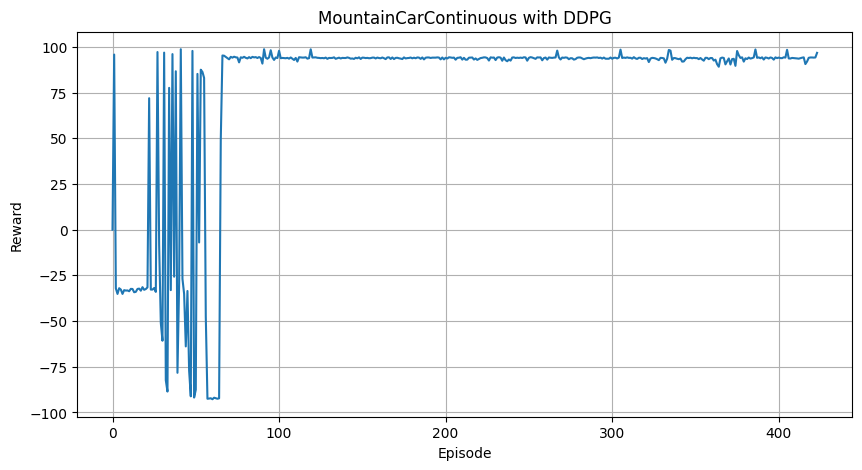

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(evaluations_ddpg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MountainCarContinuous with DDPG')
plt.grid()
plt.show()

In [8]:
evaluation_td3 = main(policy_name = 'TD3')

---------------------------------------
Evaluation over 10 episodes: -0.270
---------------------------------------
Total T: 112 Episode Num: 1 Episode T: 112 Reward: 95.797
Total T: 1111 Episode Num: 2 Episode T: 999 Reward: -32.107
Total T: 2110 Episode Num: 3 Episode T: 999 Reward: -35.172
Total T: 3109 Episode Num: 4 Episode T: 999 Reward: -32.049
Total T: 4108 Episode Num: 5 Episode T: 999 Reward: -32.772
Total T: 5107 Episode Num: 6 Episode T: 999 Reward: -35.160
Total T: 6106 Episode Num: 7 Episode T: 999 Reward: -33.100
Total T: 7105 Episode Num: 8 Episode T: 999 Reward: -33.337
Total T: 8104 Episode Num: 9 Episode T: 999 Reward: -33.262
Total T: 9103 Episode Num: 10 Episode T: 999 Reward: -33.699
Total T: 10102 Episode Num: 11 Episode T: 999 Reward: -32.404
Total T: 11101 Episode Num: 12 Episode T: 999 Reward: -32.461
Total T: 12100 Episode Num: 13 Episode T: 999 Reward: -34.245
Total T: 13099 Episode Num: 14 Episode T: 999 Reward: -34.026
Total T: 14098 Episode Num: 15 Episod

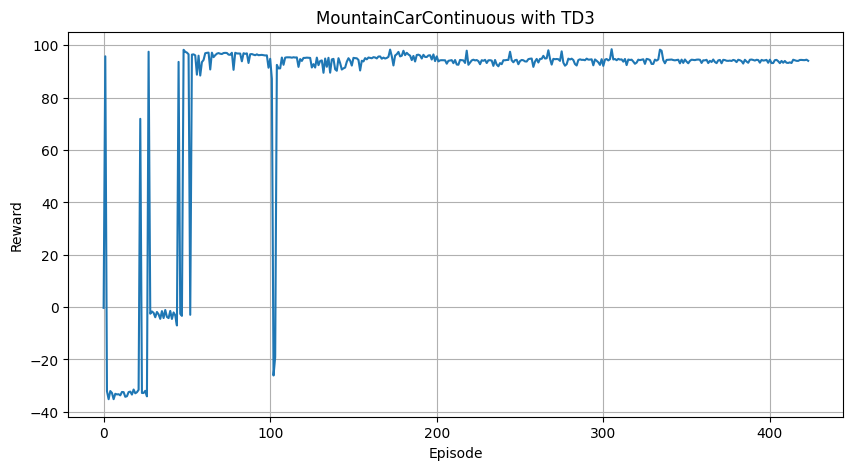

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(evaluation_td3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MountainCarContinuous with TD3')
plt.grid()
plt.show()